# Retention Curves

To start we'll need to do some imports and load the [Jupysql](https://jupysql.ploomber.io/en/latest/quick-start.html) extension which allows is to conveniently write SQL directly in cells.

In [1]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt

%load_ext sql

We'll also set some Jupysql configuration options. Other options can be viewed [here](https://jupysql.ploomber.io/en/latest/api/configuration.html).

In [2]:
# Return the resultset as a pandas dataframe
%config SqlMagic.autopandas = True

# Verbosity level. 0=minimal, 1=normal, 2=all
%config SqlMagic.feedback = 0

# Show connection string after execution
%config SqlMagic.displaycon = False

%config SqlMagic.displaylimit = 10

Connnect to an **in-memory** duckdb database.

In [3]:
%sql duckdb:///:default:

And now we are ready to do a little data wrangling.

The dataset we'll be using was downloaded from [Kaggle](https://www.kaggle.com/datasets/gabrielsantello/wholesale-and-retail-orders-dataset) and consists of a single csv containing order lines. Let's look at a sample.

In [4]:
%sql select * from read_csv_auto('./data/retail_orders/orders.csv') limit 5;

,Customer ID,Customer Status,Date Order was placed,Delivery Date,Order ID,Product ID,Quantity Ordered,Total Retail Price for This Order,Cost Price Per Unit
0,579,Silver,01-Jan-17,07-Jan-17,123002578,220101400106,2,92.6,20.70
1,7574,SILVER,01-Jan-17,05-Jan-17,123004074,210201000009,1,21.7,9.95
2,28861,Gold,01-Jan-17,04-Jan-17,123000871,230100500068,1,1.7,0.80
3,43796,Gold,01-Jan-17,06-Jan-17,123002851,220100100633,1,47.9,24.05
4,54673,Gold,01-Jan-17,04-Jan-17,123003607,220200200043,1,36.9,18.30


It looks like some basic wrangling like renaming the columns, setting the date format and standardising the status column is needed. 

In [5]:
%%sql

-- Read in the csv file and rename the columns and set the dateformat

create or replace table orders as select * from read_csv_auto(
    './data/retail_orders/orders.csv', 
    names=[
        'customer_id', 
        'status', 
        'order_date', 
        'delivery_date', 
        'order_id', 
        'product_id', 
        'qty', 
        'total', 
        'unit_cost', 
    ],
    skip=1,
    dateformat='%d-%b-%y'
);

-- Standardise the status column as lowercase

update orders set status = lower(status) where lower(status) <> status;

,Success


In [9]:
%%sql

with cte as (
select customer_id
,count(distinct(order_id)) as num_orders 
from orders group by customer_id 
order by num_orders desc
)
select num_orders, count(*) as cnt 
from cte group by num_orders 
order by num_orders;

,num_orders,cnt
0,1,15008
1,2,12056
2,3,9087
3,4,6526
4,5,4497
5,6,3029
6,7,2010
7,8,1287
8,9,889
9,10,548


How many customers in each period will go on to buy in following periods

In [43]:
%%sql --save retention_months --no-execute

with nums as (
  select generate_series as num from generate_series(0,500) 
),

cte1 as (select customer_id
,first_value(order_date) over cust_orders as first_order
,last_value(order_date) over cust_orders as last_order
,order_date
from orders 
window cust_orders as (
    partition by customer_id order by order_date asc
    rows between unbounded preceding and unbounded following
)
order by customer_id, order_date),

cte2 as (
select customer_id
,first_order
,last_order
,date_diff('month', first_order, last_order) as periods 
from cte1),

cte3 as (
select periods
,count(*) as cnt 
from cte2 
group by periods 
order by periods asc
)

select num, sum(cnt) as retained from cte3 join nums n on n.num <= periods group by num order by num; 

Skipping execution...

Generating CTE with stored snippets: 'retention_months'

<Axes: xlabel='num'>

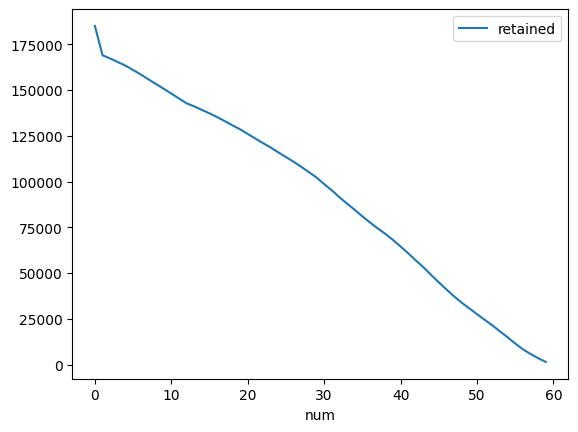

In [42]:
result = %sql select * from retention_months;
result.set_index("num").plot()